In [177]:
import random
import pandas as pd

import psycopg2 as pg
import sqlalchemy


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.weight': 'bold'})

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None


def getBoxPlotData(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)


In [178]:
from sqlalchemy import create_engine

POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres'
POSTGRES_PASSWORD = 'postgres'
POSTGRES_DBNAME = 'mam'

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))

cnx = create_engine(postgres_str)

# Select first 5 rows
pd.read_sql_query('''SELECT * FROM scalars LIMIT 5;''', cnx)



,node_amount,area_sq_m,lpn_fn_ratio,relay_type,delta_ms,speed_ms,series,rep,module,name,type,value,full_row,created_at
0,100,400,4,MAMRELAY,10000,6,4,0,MAM_n100_a400m2_lpnFn4_4.host_lpn_59.ipv4.ip,packetDropHopLimitReached:count,scalar,0.0,MAM_n100_a400m2_lpnFn4_4-MAMRELAY-31-20201223-...,2020-12-28
1,100,400,4,MAMRELAY,10000,6,4,0,MAM_n100_a400m2_lpnFn4_4.host_lpn_59.ipv4.ip,packetDropHopLimitReached:sum(packetBytes),scalar,0.0,MAM_n100_a400m2_lpnFn4_4-MAMRELAY-31-20201223-...,2020-12-28
2,100,400,4,MAMRELAY,10000,6,4,0,MAM_n100_a400m2_lpnFn4_4.host_lpn_59.ipv4.ip,packetDropForwardingDisabled:count,scalar,0.0,MAM_n100_a400m2_lpnFn4_4-MAMRELAY-31-20201223-...,2020-12-28
3,100,400,4,MAMRELAY,10000,6,4,0,MAM_n100_a400m2_lpnFn4_4.host_lpn_59.ipv4.ip,packetDropForwardingDisabled:sum(packetBytes),scalar,0.0,MAM_n100_a400m2_lpnFn4_4-MAMRELAY-31-20201223-...,2020-12-28
4,100,400,4,MAMRELAY,10000,6,4,0,MAM_n100_a400m2_lpnFn4_4.host_lpn_59.ipv4.ip,packetDropNoInterfaceFound:count,scalar,0.0,MAM_n100_a400m2_lpnFn4_4-MAMRELAY-31-20201223-...,2020-12-28


In [179]:
# Select distinct name values (https://wiki.postgresql.org/wiki/Loose_indexscan)
allNames = pd.read_sql_query('''
WITH RECURSIVE t AS (
   SELECT min(name) AS name FROM scalars
   UNION ALL
   SELECT (SELECT min(name) FROM scalars WHERE name > t.name)
   FROM t WHERE t.name IS NOT NULL
   )
SELECT name FROM t WHERE name IS NOT NULL
UNION ALL
SELECT null WHERE EXISTS(SELECT 1 FROM scalars WHERE name IS NULL);
''', cnx)['name']

allNames

0            *.collector*.app[0].destPort
1           *.collector*.app[0].localPort
2           *.collector*.app[0].startTime
3            *.collector*.app[0].typename
4          *.collector*.ipv4.arp.typename
                      ...                
164             symbolErrorRate:histogram
165                    transmission count
166               transmissionState:count
167    unique data packets bytes received
168          unique data packets received
Name: name, Length: 169, dtype: object

In [180]:
trackedNames = [
    'realDataEndToEndDelay:histogram', 
    'residualEnergyCapacity:last', 
    'unique data packets bytes received', 
    'repeated data packets bytes received'
]

trackedPrefixes = [
    'generated packet uuids-part',
    'received packet uuids-part'
]

for x in allNames:
    for y in trackedPrefixes:
        if x.startswith(y):
            trackedNames.append(x)
            

trackedNames

['realDataEndToEndDelay:histogram',
 'residualEnergyCapacity:last',
 'unique data packets bytes received',
 'repeated data packets bytes received',
 'generated packet uuids-part1',
 'generated packet uuids-part2',
 'generated packet uuids-part3',
 'received packet uuids-part1',
 'received packet uuids-part10',
 'received packet uuids-part11',
 'received packet uuids-part2',
 'received packet uuids-part3',
 'received packet uuids-part4',
 'received packet uuids-part5',
 'received packet uuids-part6',
 'received packet uuids-part7',
 'received packet uuids-part8',
 'received packet uuids-part9']

In [181]:
# Select distinct Delta values (https://wiki.postgresql.org/wiki/Loose_indexscan)
allDeltas = pd.read_sql_query('''
WITH RECURSIVE t AS (
   SELECT min(delta_ms) AS delta_ms FROM scalars
   UNION ALL
   SELECT (SELECT min(delta_ms) FROM scalars WHERE delta_ms > t.delta_ms)
   FROM t WHERE t.delta_ms IS NOT NULL
   )
SELECT delta_ms FROM t WHERE delta_ms IS NOT NULL
UNION ALL
SELECT null WHERE EXISTS(SELECT 1 FROM scalars WHERE delta_ms IS NULL);
''', cnx)

allDeltas = allDeltas['delta_ms']
#allDeltas = allDeltas[allDeltas <= 500]
#allDeltas = allDeltas[allDeltas != 2]

allDeltas.sort_values()

allDeltas

0         0
1         2
2         5
3        10
4        20
5        50
6       100
7       500
8      1000
9      5000
10    10000
11    15000
12    20000
Name: delta_ms, dtype: int64

In [182]:
primaryKeyColumns = ['node_amount', 'area_sq_m', 'lpn_fn_ratio', 'relay_type', 'delta_ms', 'speed_ms', 'series', 'rep']
primaryKeyColumnsCSV = ','.join(primaryKeyColumns)
tPrimaryKeyColumnsCSV = ','.join(['t.' + x for x in primaryKeyColumns])

allRuns = pd.read_sql_query('''
WITH RECURSIVE
     t AS (
  select ''' + primaryKeyColumnsCSV + ''' from
    (select ''' + primaryKeyColumnsCSV + ''' from scalars
    order by ''' + primaryKeyColumnsCSV + ''' limit 1) asdf
  union all
  select '''
     +
     ','.join(['(select ' + x + ' from scalars where (' + primaryKeyColumnsCSV + ') > (' + tPrimaryKeyColumnsCSV + ') order by ' + primaryKeyColumnsCSV + ' limit 1)' for x in primaryKeyColumns])
     +                       
  '''from t where t.''' + primaryKeyColumns[0] + ''' is not null)
select * from t where t.''' + primaryKeyColumns[0] + ''' is not null;
''', cnx)
allRuns

,node_amount,area_sq_m,lpn_fn_ratio,relay_type,delta_ms,speed_ms,series,rep
0,50,400,4,BMRELAY,0,2,0,0
1,50,400,4,BMRELAY,0,2,1,0
2,50,400,4,BMRELAY,0,2,2,0
3,50,400,4,BMRELAY,0,2,3,0
4,50,400,4,BMRELAY,0,2,4,0
...,...,...,...,...,...,...,...,...
11067,200,1000,12,MAMRELAY,20000,14,5,0
11068,200,1000,12,MAMRELAY,20000,14,6,0
11069,200,1000,12,MAMRELAY,20000,14,7,0
11070,200,1000,12,MAMRELAY,20000,14,8,0


In [183]:
lastRun = allRuns.iloc[len(allRuns)-1]
lastRunDeliveryRate = pd.read_sql_query('select * from scalars where node_amount=' + str(lastRun['node_amount']) + 
' and area_sq_m=' + str(lastRun['area_sq_m']) + ' and lpn_fn_ratio='+ str(lastRun['lpn_fn_ratio']) +
' and relay_type=\'' + str(lastRun['relay_type']) + '\' and delta_ms='+ str(lastRun['delta_ms']) + 
' and speed_ms=' + str(lastRun['speed_ms']) + ' and series='+ str(lastRun['series']) + ' and rep=' + str(lastRun['rep']) + 
''' and (name = 'delivery rate') ''', cnx)

if lastRunDeliveryRate.empty:
    raise Exception('Non-existent delivery rate. Make sure to have run MAM-Large-Generate-Delivery-Rate-Scalars notebook')

lastRunDeliveryRate

,node_amount,area_sq_m,lpn_fn_ratio,relay_type,delta_ms,speed_ms,series,rep,module,name,type,value,full_row,created_at
0,200,1000,12,MAMRELAY,20000,14,9,0,MAM-Large-Generate-Delivery-Rate-Scalars,delivery rate,None,9.113396693138915,None,2021-02-04


In [184]:
pd.read_sql_query('''
SELECT count(*) from scalars where delta_ms=100 and name in (''' + ','.join(["'" + x + "'" for x in trackedNames]) + ''')
limit 10
''', cnx)



,count
0,189279


In [8]:
pd.read_sql_query('''
SELECT delta_ms,relay_type,lpn_fn_ratio,sum(cast(value as DOUBLE PRECISION)) from scalars where name='residualEnergyCapacity:last' group by delta_ms,relay_type,lpn_fn_ratio
''', cnx)

,delta_ms,relay_type,lpn_fn_ratio,sum
0,0,BMRELAY,4,-48620.263677
1,0,BMRELAY,8,-34583.575800
2,0,BMRELAY,12,-28301.724869
3,0,MAMRELAY,4,-15265.914491
4,0,MAMRELAY,8,-15004.474681
5,0,MAMRELAY,12,-14979.254045
6,2,MAMRELAY,4,-15177.673663
7,2,MAMRELAY,8,-15060.575535
8,2,MAMRELAY,12,-15038.833370
9,5,MAMRELAY,4,-15020.635922


In [186]:
BP_QUERY_SUFFIX = '''
details AS (
SELECT series,
       value,
       ROW_NUMBER() OVER (PARTITION BY series ORDER BY value) AS row_number,
       SUM(1) OVER (PARTITION BY series) AS total
  FROM raw_data
),

quartiles AS (
SELECT series,
       value,
       AVG(CASE WHEN row_number >= (FLOOR(total/2.0)/2.0) 
                 AND row_number <= (FLOOR(total/2.0)/2.0) + 1 
                THEN value/1.0 ELSE NULL END
          ) OVER (PARTITION BY series) AS q1,
       AVG(CASE WHEN row_number >= (total/2.0) 
                 AND row_number <= (total/2.0) + 1 
                THEN value/1.0 ELSE NULL END
          ) OVER (PARTITION BY series) AS median,
       AVG(CASE WHEN row_number >= (CEIL(total/2.0) + (FLOOR(total/2.0)/2.0))
                 AND row_number <= (CEIL(total/2.0) + (FLOOR(total/2.0)/2.0) + 1) 
                THEN value/1.0 ELSE NULL END
          ) OVER (PARTITION BY series) AS q3
  FROM details
)

SELECT series,
       MIN(value) AS minimum,
       AVG(q1) AS q1,
       AVG(median) AS median,
       AVG(q3) AS q3,
       MAX(value) AS maximum
  FROM quartiles
 GROUP BY 1
 ORDER BY 4
'''

energyDrawBPdata = pd.read_sql_query('''
WITH raw_data AS (

SELECT CONCAT(relay_type,'-',lpn_fn_ratio) as series, cast(value as DOUBLE PRECISION)*-1.0 as value 
      from scalars 
      where name='residualEnergyCapacity:last'
      
),
 
''' + BP_QUERY_SUFFIX, cnx)

energyDrawBPdata

,series,minimum,q1,median,q3,maximum
0,MAMRELAY-12,0.000295,0.459400,0.499951,0.538752,1.950528
1,MAMRELAY-8,0.000142,0.459441,0.505953,0.550066,2.283924
2,MAMRELAY-4,0.000147,0.472863,0.519413,0.574688,4.494737
3,BMRELAY-12,0.034331,0.506076,0.693329,1.223284,5.823802
4,BMRELAY-8,0.000160,0.512867,0.905168,1.599817,5.703887
5,BMRELAY-4,0.065259,0.684930,1.598713,1.750594,5.665468


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,MAM-LPN/FN=12,0.065259,0.684930,1.598713,1.750594,1.750594
1,MAM-LPN/FN=8,0.000160,0.512867,0.905168,1.599817,1.599817
2,MAM-LPN/FN=4,0.034331,0.506076,0.693329,1.223284,1.223284
3,BM-LPN/FN=12,0.472863,0.472863,0.519413,0.574688,0.574688
4,BM-LPN/FN=8,0.459441,0.459441,0.505953,0.550066,0.550066
5,BM-LPN/FN=4,0.459400,0.459400,0.499951,0.538752,0.538752


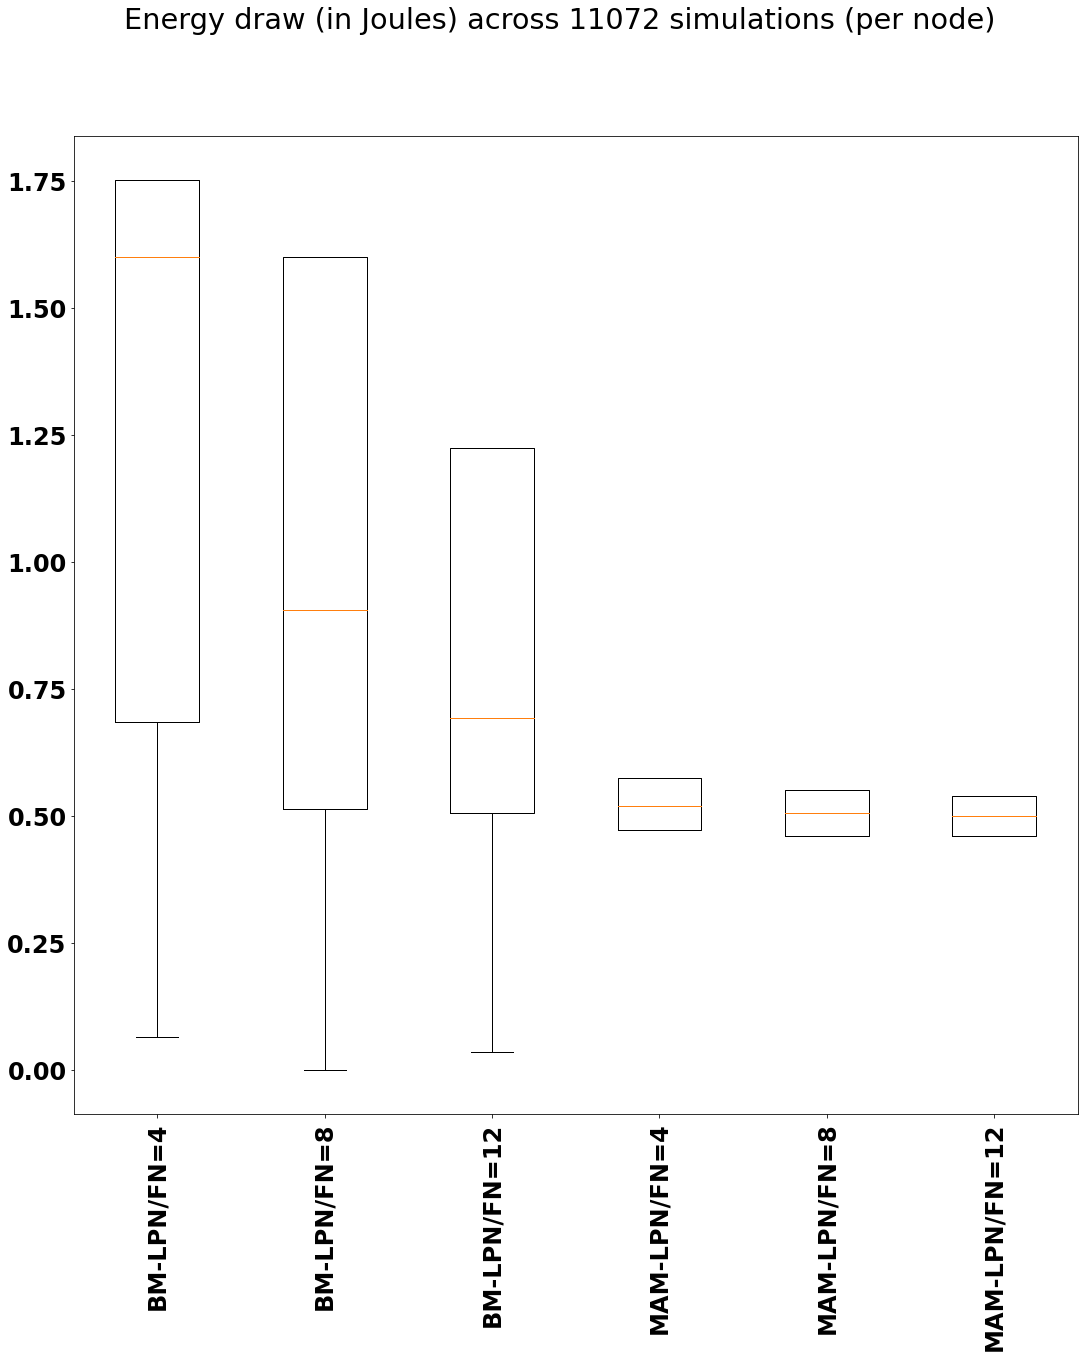

In [196]:
energyDrawBPdata

# Create a figure instance
fig = plt.figure(1, figsize=(18, 18))

# Create an axes instance
ax = fig.add_subplot(111)

labels = energyDrawBPdata['series'].str.replace('RELAY-','-LPN/FN=')

data = []

for row in energyDrawBPdata.iterrows():
    x = row[1]
    data.append([x['minimum'], x['q1'], x['median'], x['q3'], x['maximum']])

bp = ax.boxplot(data, showfliers=False)

plt.suptitle('Energy draw (in Joules) across ' + str(len(allRuns)) + ' simulations (per node)')

plt.xticks(rotation='90.0')
ax.set_xticklabels(labels)

# Save the figure
fig.savefig('mamset-fig1.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

In [11]:
pd.read_sql_query('''
SELECT node_amount, area_sq_m, lpn_fn_ratio, relay_type, delta_ms, speed_ms, series, rep, name, sum(cast(value as DOUBLE PRECISION)*-1.0) as value
      from scalars
      where name='residualEnergyCapacity:last'
      group by node_amount, area_sq_m, lpn_fn_ratio, relay_type, delta_ms, speed_ms, series, rep, name
      LIMIT 1
''', cnx)

,node_amount,area_sq_m,lpn_fn_ratio,relay_type,delta_ms,speed_ms,series,rep,name,value
0,50,400,4,BMRELAY,0,2,0,0,residualEnergyCapacity:last,27.884309


In [12]:
energyDrawBPdata = pd.read_sql_query('''
WITH raw_data AS (

SELECT CONCAT(relay_type,'-',lpn_fn_ratio) as series, sum(cast(value as DOUBLE PRECISION)*-1.0) as value 
      from scalars 
      where name='residualEnergyCapacity:last'
      group by node_amount, area_sq_m, lpn_fn_ratio, relay_type, delta_ms, speed_ms, series, rep, name
            
),
 
''' + BP_QUERY_SUFFIX, cnx)

energyDrawBPdata

,series,minimum,q1,median,q3,maximum
0,MAMRELAY-4,19.229121,22.844937,46.730175,95.463008,355.098353
1,MAMRELAY-12,19.308013,23.093228,46.745267,93.991226,112.868861
2,MAMRELAY-8,14.204125,22.717503,46.749927,94.615266,153.260672
3,BMRELAY-12,20.182553,23.716961,54.754811,150.003287,330.160598
4,BMRELAY-8,16.229727,25.278501,78.932472,190.938367,349.622961
5,BMRELAY-4,21.865806,30.523911,182.311220,369.690594,402.330143


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,MAM-LPN/FN=12,0.065259,0.684930,1.598713,1.750594,1.750594
1,MAM-LPN/FN=8,0.000160,0.512867,0.905168,1.599817,1.599817
2,MAM-LPN/FN=4,0.034331,0.506076,0.693329,1.223284,1.223284
3,BM-LPN/FN=12,0.472863,0.472863,0.519413,0.574688,0.574688
4,BM-LPN/FN=8,0.459441,0.459441,0.505953,0.550066,0.550066
5,BM-LPN/FN=4,0.459400,0.459400,0.499951,0.538752,0.538752


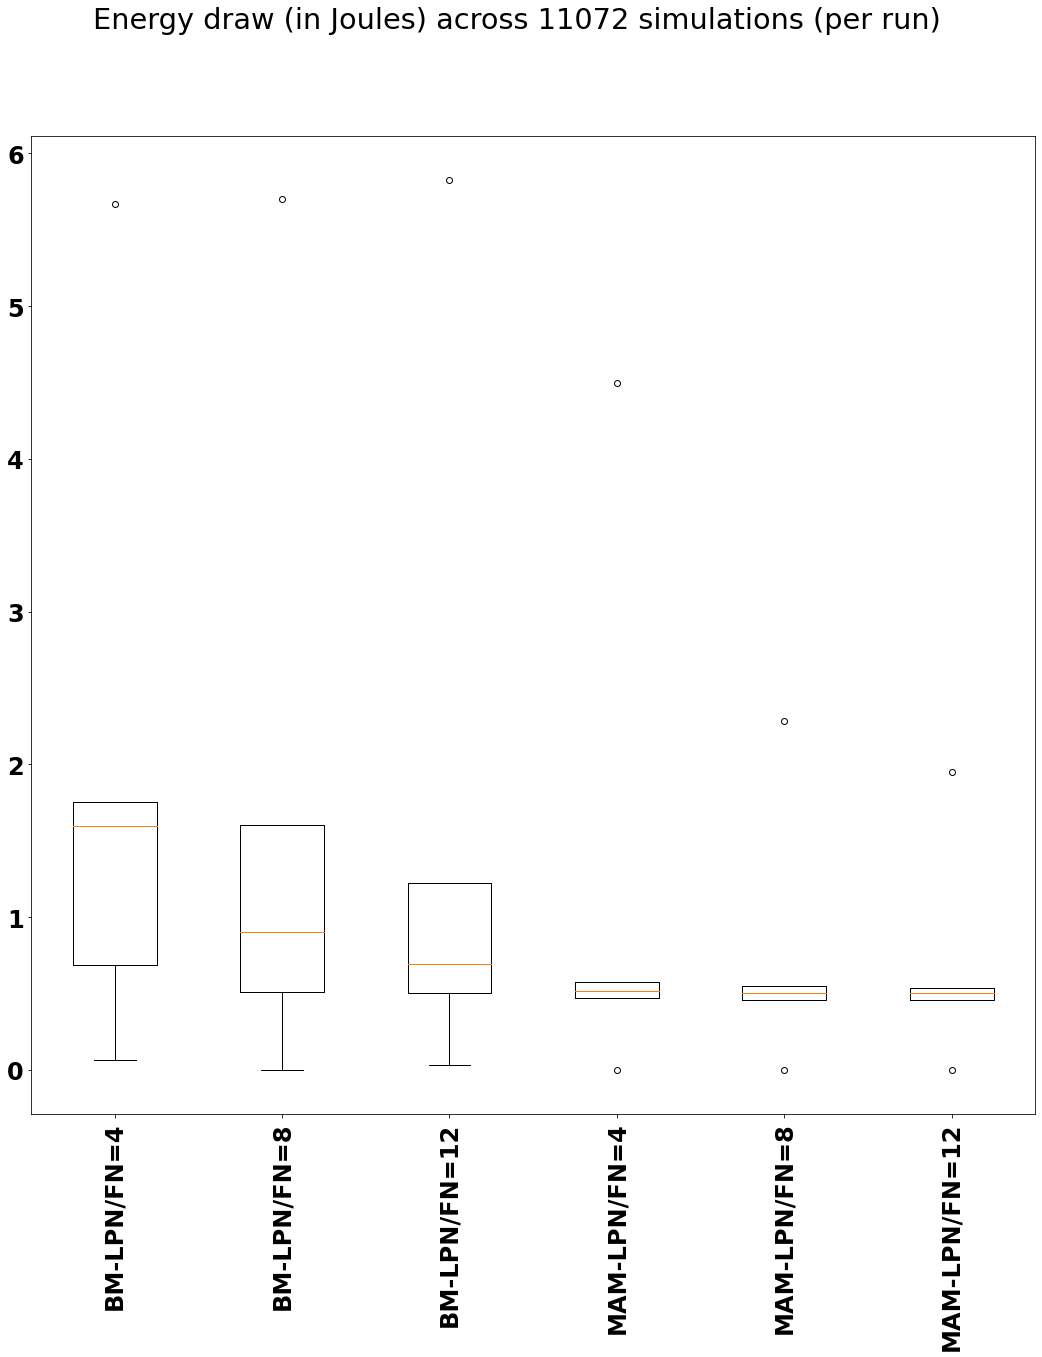

In [197]:
energyDrawBPdata['sortcol1'] = pd.DataFrame(energyDrawBPdata['series'].str.split('-').str[0])
energyDrawBPdata['sortcol2'] = pd.DataFrame(pd.to_numeric(energyDrawBPdata['series'].str.split('-').str[1]))

energyDrawBPdata = energyDrawBPdata.sort_values(by=['sortcol1','sortcol2'])

# Create a figure instance
fig = plt.figure(1, figsize=(18, 18))

# Create an axes instance
ax = fig.add_subplot(111)

labels = energyDrawBPdata['series'].str.replace('RELAY-','-LPN/FN=')

data = []

for row in energyDrawBPdata.iterrows():
    x = row[1]
    data.append([x['minimum'], x['q1'], x['median'], x['q3'], x['maximum']])

bp = ax.boxplot(data, showfliers=True)

plt.suptitle('Energy draw (in Joules) across ' + str(len(allRuns)) + ' simulations (per run)')

plt.xticks(rotation='90.0')
ax.set_xticklabels(labels)

# Save the figure
fig.savefig('mamset-fig2.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

In [14]:
uniqueDataPacketsBPData = pd.read_sql_query('''
WITH raw_data AS (

SELECT CONCAT(relay_type,'-',delta_ms) as series, cast(value as DOUBLE PRECISION) as value 
      from scalars 
      where name='unique data packets bytes received'
      
),
 
''' + BP_QUERY_SUFFIX, cnx)

# We can see that the Delta=50/Delta=100 presented the best median values for MAM-RELAY (8778-8800), 
# which is similar to the behavior we noticed with the original tests (MAM50)

uniqueDataPacketsBPData['sortcol'] = pd.DataFrame(pd.to_numeric(uniqueDataPacketsBPData['series'].str.split('-').str[1]))
uniqueDataPacketsBPData = uniqueDataPacketsBPData.sort_values('sortcol')
uniqueDataPacketsBPData



,series,minimum,q1,median,q3,maximum,sortcol
0,MAMRELAY-0,1001.0,5786.0,8002.5,12738.0,29777.0,0
13,BMRELAY-0,1122.0,11242.0,18315.0,28061.0,65736.0,0
1,MAMRELAY-2,1089.0,5973.0,8096.0,12925.0,30657.0,2
3,MAMRELAY-5,1155.0,5885.0,8294.0,13299.0,34078.0,5
5,MAMRELAY-10,1012.0,6050.0,8338.0,13739.0,34067.0,10
10,MAMRELAY-20,1111.0,6154.5,8756.0,14003.0,35420.0,20
12,MAMRELAY-50,858.0,6160.0,8800.0,13997.5,38753.0,50
11,MAMRELAY-100,1144.0,6248.0,8778.0,14465.0,39545.0,100
9,MAMRELAY-500,1122.0,6237.0,8723.0,14586.0,65307.0,500
8,MAMRELAY-1000,1100.0,6105.0,8426.0,13552.0,35013.0,1000


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,MAM-Δ=0,1001.0,5786.0,8002.5,12738.0,12738.0
1,MAM-Δ=2,1122.0,11242.0,18315.0,28061.0,28061.0
2,MAM-Δ=5000,1089.0,5973.0,8096.0,12925.0,12925.0
3,MAM-Δ=5,1155.0,5885.0,8294.0,13299.0,13299.0
4,MAM-Δ=10000,1012.0,6050.0,8338.0,13739.0,13739.0
5,MAM-Δ=10,1111.0,6154.5,8756.0,14003.0,14003.0
6,MAM-Δ=20000,858.0,6160.0,8800.0,13997.5,13997.5
7,MAM-Δ=15000,1144.0,6248.0,8778.0,14465.0,14465.0
8,MAM-Δ=1000,1122.0,6237.0,8723.0,14586.0,14586.0
9,MAM-Δ=500,1100.0,6105.0,8426.0,13552.0,13552.0


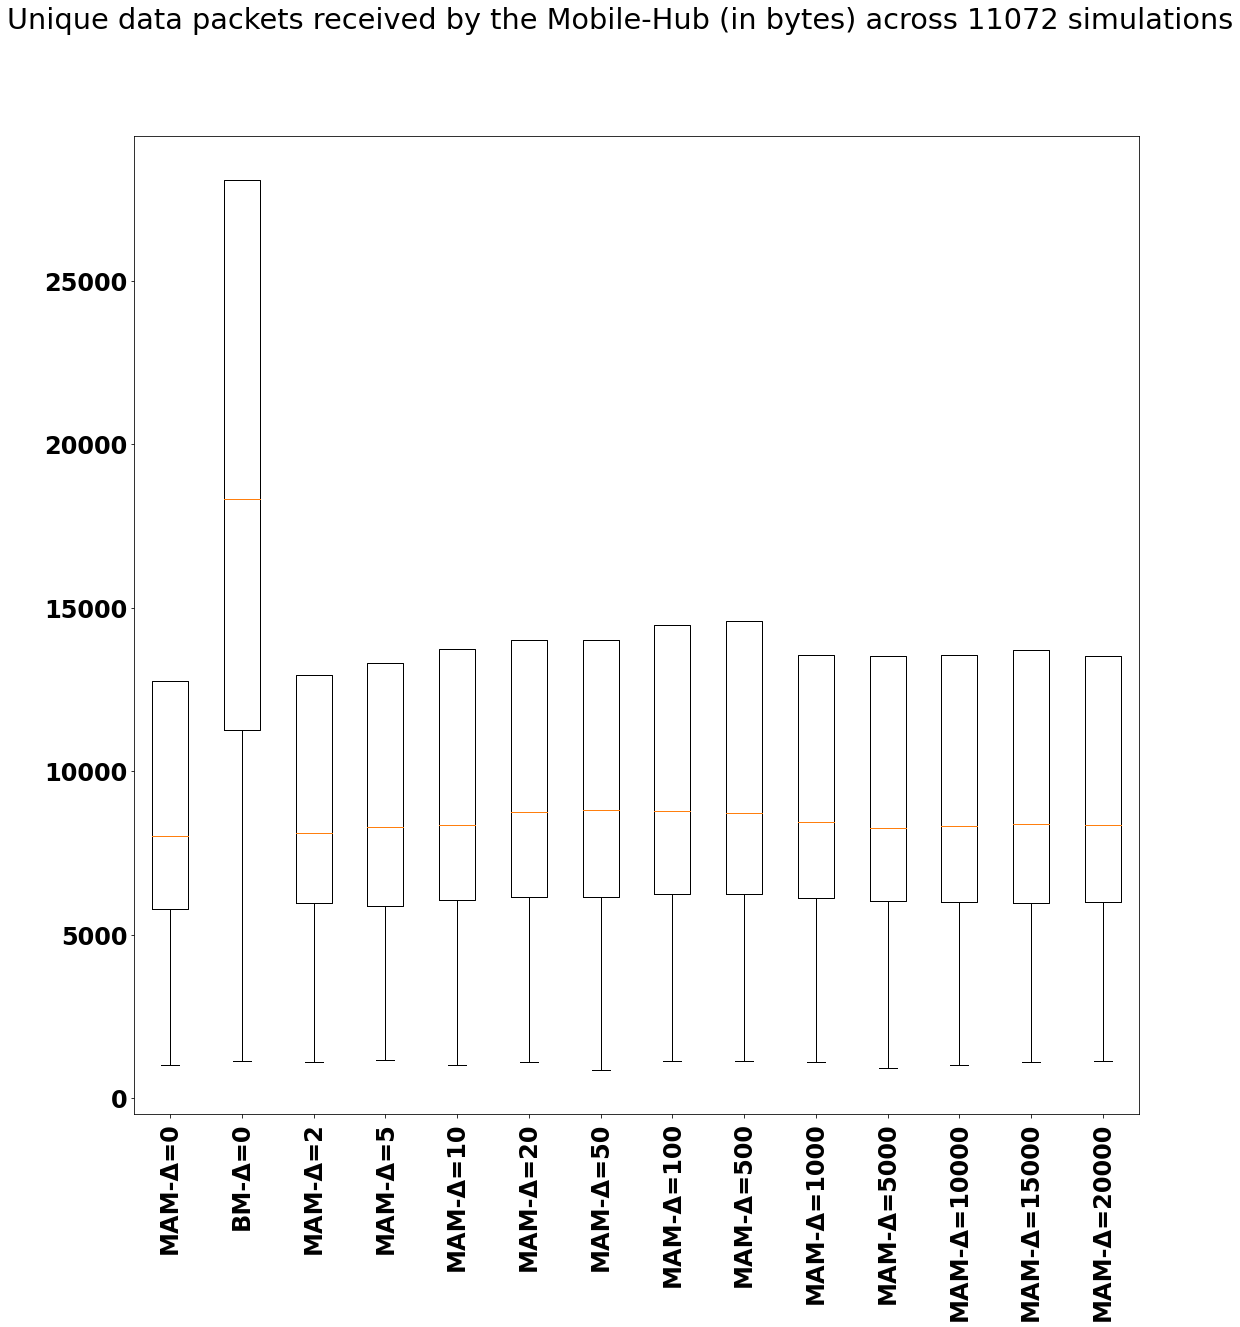

In [198]:
# Create a figure instance
fig = plt.figure(1, figsize=(18, 18))

# Create an axes instance
ax = fig.add_subplot(111)

labels = uniqueDataPacketsBPData['series'].str.replace('RELAY-','-Δ=')

data = []

for row in uniqueDataPacketsBPData.iterrows():
    x = row[1]
    data.append([x['minimum'], x['q1'], x['median'], x['q3'], x['maximum']])

bp = ax.boxplot(data, showfliers=False)

plt.suptitle('Unique data packets received by the Mobile-Hub (in bytes) across ' + str(len(allRuns)) + ' simulations')

plt.xticks(rotation='90.0')
ax.set_xticklabels(labels)

# Save the figure
fig.savefig('mamset-fig3.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

In [16]:
bytesPerJouleBPdata = pd.read_sql_query('''
WITH raw_data AS (

WITH dataSet AS (
    SELECT node_amount, area_sq_m, lpn_fn_ratio, relay_type, delta_ms, speed_ms, series, rep, name, sum(cast(value as DOUBLE PRECISION)*-1.0) as value
      from scalars
      where name='residualEnergyCapacity:last' and (relay_type='BMRELAY' or delta_ms=100)
      group by node_amount, area_sq_m, lpn_fn_ratio, relay_type, delta_ms, speed_ms, series, rep, name
    UNION ALL
    SELECT node_amount, area_sq_m, lpn_fn_ratio, relay_type, delta_ms, speed_ms, series, rep, name, cast(value as DOUBLE PRECISION) as value
        from scalars where name='unique data packets bytes received' and (relay_type='BMRELAY' or delta_ms=100))
        SELECT CONCAT(d1.relay_type,'-',d1.lpn_fn_ratio) as series, d1.value/d2.value as value from dataSet d1 inner join dataSet d2 on
            d1.node_amount=d2.node_amount and d1.area_sq_m=d2.area_sq_m and d1.lpn_fn_ratio=d2.lpn_fn_ratio and
            d1.relay_type=d2.relay_type and d1.delta_ms=d2.delta_ms and d1.speed_ms=d2.speed_ms and d1.series=d2.series and
            d1.rep=d2.rep and d1.name != d2.name
            WHERE d1.name='unique data packets bytes received' and d2.name = 'residualEnergyCapacity:last'
      
),
 
''' + BP_QUERY_SUFFIX, cnx)

bytesPerJouleBPdata

,series,minimum,q1,median,q3,maximum
0,MAMRELAY-12,20.453900,100.043662,177.515393,284.470402,932.829126
1,BMRELAY-4,13.787325,90.126246,181.743201,402.459955,1138.916804
2,MAMRELAY-8,13.051897,115.298439,204.652467,318.035963,927.774355
3,BMRELAY-8,26.197435,123.913479,213.660863,402.688018,1118.297655
4,MAMRELAY-4,18.544327,143.827857,240.693595,362.676470,1067.721347
5,BMRELAY-12,36.523522,153.463184,253.184618,393.592309,1068.998005


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,MAM-LPN/FN=12,13.787325,90.126246,181.743201,402.459955,402.459955
1,BM-LPN/FN=4,26.197435,123.913479,213.660863,402.688018,402.688018
2,MAM-LPN/FN=8,36.523522,153.463184,253.184618,393.592309,393.592309
3,BM-LPN/FN=8,18.544327,143.827857,240.693595,362.676470,362.676470
4,MAM-LPN/FN=4,13.051897,115.298439,204.652467,318.035963,318.035963
5,BM-LPN/FN=12,20.453900,100.043662,177.515393,284.470402,284.470402


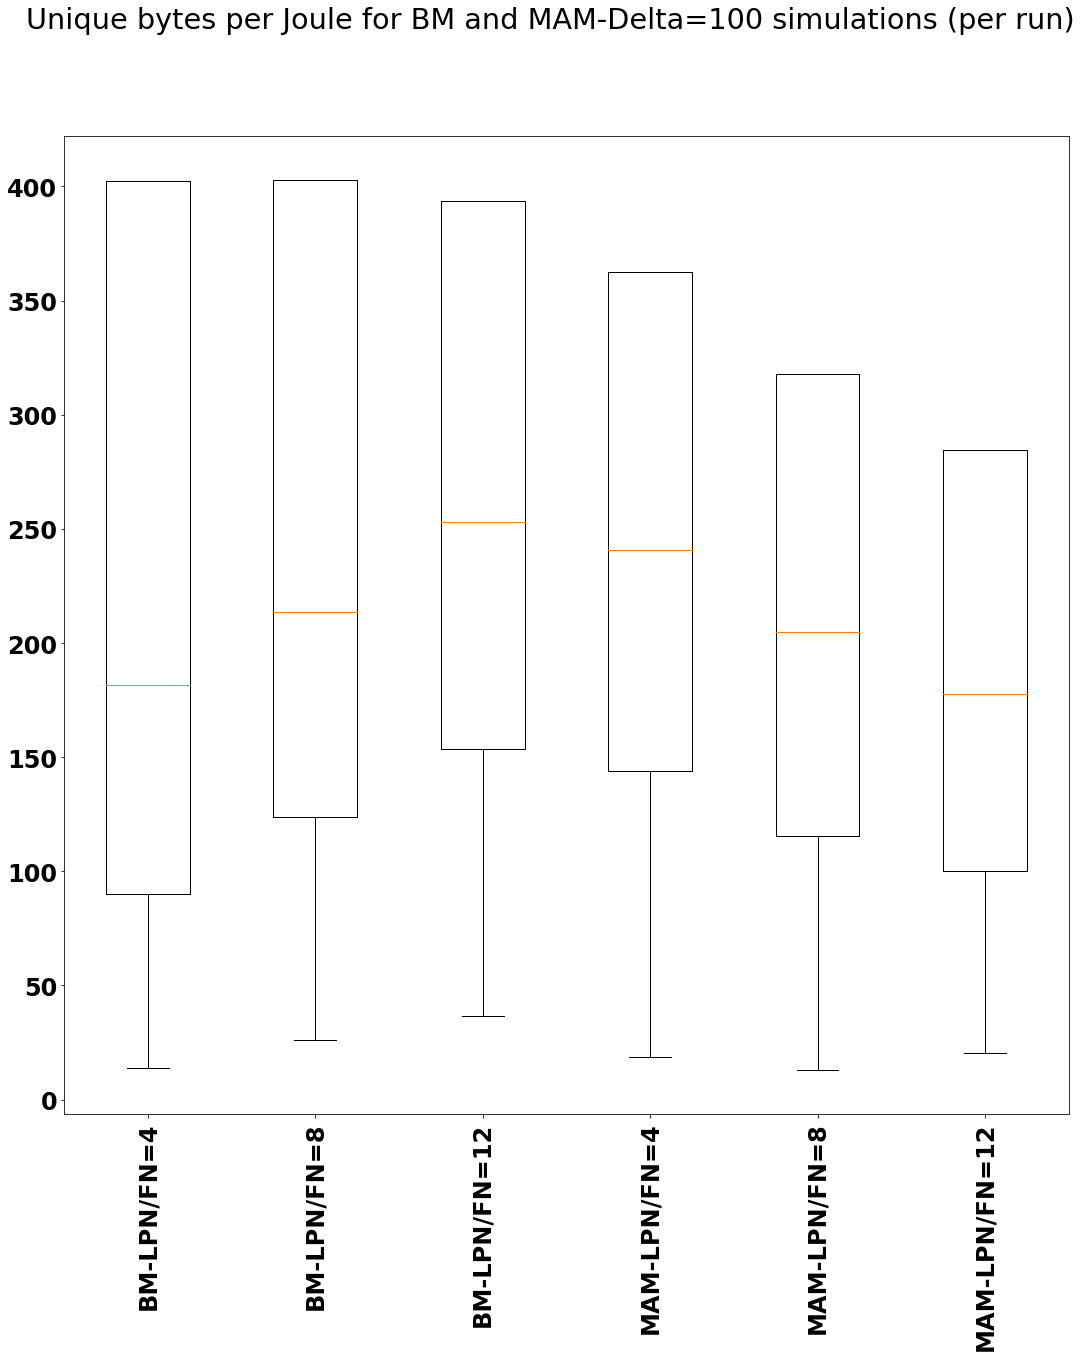

In [199]:
bytesPerJouleBPdata['sortcol1'] = pd.DataFrame(bytesPerJouleBPdata['series'].str.split('-').str[0])
bytesPerJouleBPdata['sortcol2'] = pd.DataFrame(pd.to_numeric(bytesPerJouleBPdata['series'].str.split('-').str[1]))

bytesPerJouleBPdata = bytesPerJouleBPdata.sort_values(by=['sortcol1','sortcol2'])

# Create a figure instance
fig = plt.figure(1, figsize=(18, 18))

# Create an axes instance
ax = fig.add_subplot(111)

labels = bytesPerJouleBPdata['series'].str.replace('RELAY-','-LPN/FN=')

data = []

for row in bytesPerJouleBPdata.iterrows():
    x = row[1]
    data.append([x['minimum'], x['q1'], x['median'], x['q3'], x['maximum']])

bp = ax.boxplot(data, showfliers=False)

plt.suptitle('Unique bytes per Joule for BM and MAM-Delta=100 simulations (per run)')

plt.xticks(rotation='90.0')
ax.set_xticklabels(labels)

# Save the figure
fig.savefig('mamset-fig4.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

In [27]:
lastRun = allRuns.iloc[len(allRuns)-1]
lastRunDeliveryRate = pd.read_sql_query('select * from scalars where node_amount=' + str(lastRun['node_amount']) + 
' and area_sq_m=' + str(lastRun['area_sq_m']) + ' and lpn_fn_ratio='+ str(lastRun['lpn_fn_ratio']) +
' and relay_type=\'' + str(lastRun['relay_type']) + '\' and delta_ms='+ str(lastRun['delta_ms']) + 
' and speed_ms=' + str(lastRun['speed_ms']) + ' and series='+ str(lastRun['series']) + ' and rep=' + str(lastRun['rep']) + 
''' and (name = 'delivery rate') ''', cnx)

if lastRunDeliveryRate.empty:
    raise Exception('Non-existent delivery rate. Make sure to have run MAM-Large-Generate-Delivery-Rate-Scalars notebook')

lastRunDeliveryRate

,node_amount,area_sq_m,lpn_fn_ratio,relay_type,delta_ms,speed_ms,series,rep,module,name,type,value,full_row,created_at
0,200,1000,12,MAMRELAY,20000,14,9,0,MAM-Large-Generate-Delivery-Rate-Scalars,delivery rate,None,9.113396693138915,None,2021-02-04


In [46]:
deliveryRateBPdata = pd.read_sql_query('''
WITH raw_data AS (

SELECT CONCAT(relay_type,'-',lpn_fn_ratio) as series, cast(value as DOUBLE PRECISION) as value 
      from scalars 
      where name='delivery rate' and (relay_type='BMRELAY' or delta_ms=100)
),
 
''' + BP_QUERY_SUFFIX, cnx)

deliveryRateBPdata

,series,minimum,q1,median,q3,maximum
0,BMRELAY-4,0.381880,2.456043,5.631476,23.657711,34.467066
1,MAMRELAY-12,4.975554,10.634328,14.532518,19.522622,31.493157
2,MAMRELAY-4,2.717629,11.107799,14.748013,20.351788,38.147970
3,MAMRELAY-8,2.347919,11.256999,15.144455,20.791075,43.538999
4,BMRELAY-8,0.679236,4.229055,15.203300,23.422592,44.186047
5,BMRELAY-12,1.062324,6.964629,17.062754,22.773605,31.126017


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,BM-Δ=4,0.381880,2.456043,5.631476,23.657711,34.467066
1,MAM-Δ=12,0.679236,4.229055,15.203300,23.422592,44.186047
2,MAM-Δ=4,1.062324,6.964629,17.062754,22.773605,31.126017
3,MAM-Δ=8,2.717629,11.107799,14.748013,20.351788,20.351788
4,BM-Δ=8,2.347919,11.256999,15.144455,20.791075,20.791075
5,BM-Δ=12,4.975554,10.634328,14.532518,19.522622,31.493157


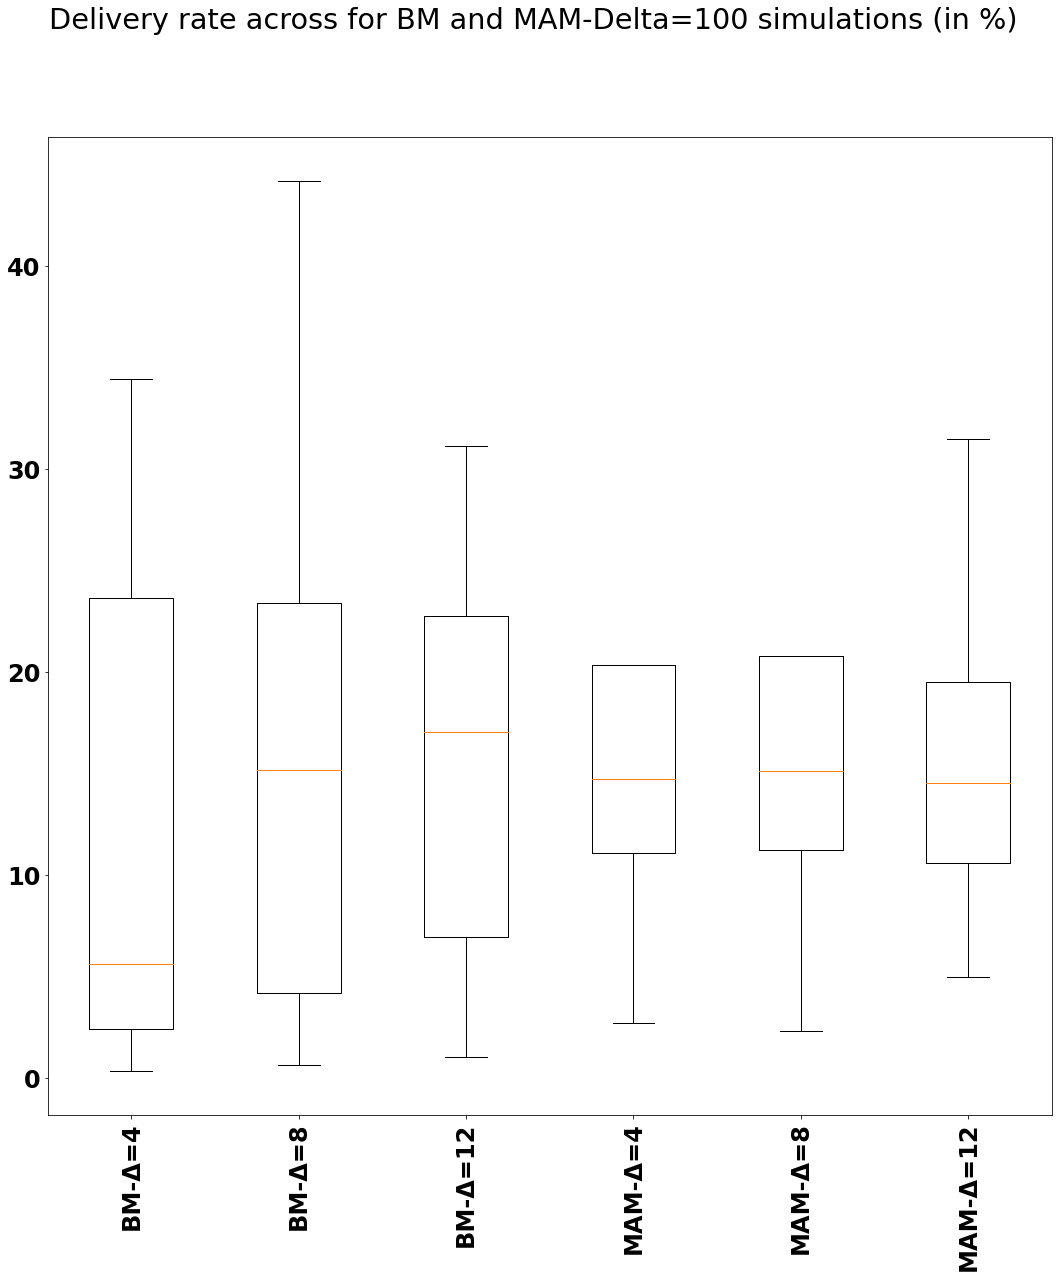

In [200]:
deliveryRateBPdata['sortcol1'] = pd.DataFrame(deliveryRateBPdata['series'].str.split('-').str[0])
deliveryRateBPdata['sortcol2'] = pd.DataFrame(pd.to_numeric(deliveryRateBPdata['series'].str.split('-').str[1]))

deliveryRateBPdata = deliveryRateBPdata.sort_values(by=['sortcol1','sortcol2'])

# Create a figure instance
fig = plt.figure(1, figsize=(18, 18))

# Create an axes instance
ax = fig.add_subplot(111)

labels = deliveryRateBPdata['series'].str.replace('RELAY-','-Δ=')

data = []

for row in deliveryRateBPdata.iterrows():
    x = row[1]
    data.append([x['minimum'], x['q1'], x['median'], x['q3'], x['maximum']])

bp = ax.boxplot(data, showfliers=False)

plt.suptitle('Delivery rate across for BM and MAM-Delta=100 simulations (in %)')

plt.xticks(rotation='90.0')
ax.set_xticklabels(labels)

# Save the figure
fig.savefig('mamset-fig5.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

In [52]:
csv_guide = 'run,type,module,name,attrname,attrvalue,value,count,sumweights,mean,stddev,min,max,binedges,binvalues'.split(',')
indexCsv = {}
i = 0
for x in csv_guide:
    indexCsv[x] = i
    i = i + 1

lastRun = allRuns.iloc[len(allRuns)-1]
endToEndDelayRows = pd.read_sql_query('select * from scalars where (relay_type=\'BMRELAY\' or delta_ms=100)' + 
''' and (name = 'realDataEndToEndDelay:histogram') ''', cnx)

endToEndDelayRows

,node_amount,area_sq_m,lpn_fn_ratio,relay_type,delta_ms,speed_ms,series,rep,module,name,type,value,full_row,created_at
0,100,800,8,BMRELAY,0,2,9,0,MAM_n100_a800m2_lpnFn8_9.collector1.app[0],realDataEndToEndDelay:histogram,histogram,None,MAM_n100_a800m2_lpnFn8_9-BMRELAY-0-20201225-13...,2020-12-28
1,50,1000,4,MAMRELAY,100,14,4,0,MAM_n50_a1000m2_lpnFn4_4.collector1.app[0],realDataEndToEndDelay:histogram,histogram,None,MAM_n50_a1000m2_lpnFn4_4-MAMRELAY-20-20201226-...,2020-12-28
2,100,800,8,BMRELAY,0,14,2,0,MAM_n100_a800m2_lpnFn8_2.collector1.app[0],realDataEndToEndDelay:histogram,histogram,None,MAM_n100_a800m2_lpnFn8_2-BMRELAY-2-20201225-14...,2020-12-28
3,50,1000,4,BMRELAY,0,14,6,0,MAM_n50_a1000m2_lpnFn4_6.collector1.app[0],realDataEndToEndDelay:histogram,histogram,None,MAM_n50_a1000m2_lpnFn4_6-BMRELAY-2-20201226-08...,2020-12-28
4,50,1000,12,BMRELAY,0,2,0,0,MAM_n50_a1000m2_lpnFn12_0.collector1.app[0],realDataEndToEndDelay:histogram,histogram,None,MAM_n50_a1000m2_lpnFn12_0-BMRELAY-0-20201226-1...,2020-12-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,50,400,8,BMRELAY,0,14,4,0,MAM_n50_a400m2_lpnFn8_4.collector1.app[0],realDataEndToEndDelay:histogram,histogram,None,MAM_n50_a400m2_lpnFn8_4-BMRELAY-2-20201223-13:...,2020-12-28
1598,100,400,12,BMRELAY,0,6,2,0,MAM_n100_a400m2_lpnFn12_2.collector1.app[0],realDataEndToEndDelay:histogram,histogram,None,MAM_n100_a400m2_lpnFn12_2-BMRELAY-1-20201223-2...,2020-12-28
1599,200,800,12,MAMRELAY,100,14,2,0,MAM_n200_a800m2_lpnFn12_2.collector1.app[0],realDataEndToEndDelay:histogram,histogram,None,MAM_n200_a800m2_lpnFn12_2-MAMRELAY-20-20201226...,2020-12-28
1600,100,800,12,BMRELAY,0,14,5,0,MAM_n100_a800m2_lpnFn12_5.collector1.app[0],realDataEndToEndDelay:histogram,histogram,None,MAM_n100_a800m2_lpnFn12_5-BMRELAY-2-20201225-1...,2020-12-28


In [74]:
endToEndDelayRows['full_row'][0].split(',')[indexCsv['binedges']]

' 0 0.8 1.6 2.4 3.2 4 4.8 5.6 6.4 7.2 8 8.8 9.6 10.4 11.2 12 12.8 13.6 14.4 15.2 16 16.8 17.6 18.4 19.2 20 20.8 21.6 22.4 23.2 24 24.8 25.6 26.4 27.2 28 28.8 29.6 30.4 31.2 32 32.8 33.6 34.4 35.2 36 36.8 37.6 38.4 39.2 40 40.8 41.6 42.4 43.2 44 44.8 45.6 46.4 47.2 48 48.8 49.6 50.4 51.2 52 52.8 53.6 54.4 55.2 56 56.8 57.6 58.4 59.2 60 60.8 61.6 62.4 63.2'

In [130]:
def explodeHistogramData(histogram):
    a = []

    i = 0
    for aa in histogram['binedges'][:-1]:
        for j in range(1,histogram['binvalues'][i]):
            a.append(aa)
        i = i + 1
    return a


In [149]:
# https://stackoverflow.com/questions/47085662/merge-histograms-with-different-ranges
# Q: Is it any fast way to merge two numpy histograms with different bin ranges and bin number?
# A: There is no unique solution to the problem of merging two different histograms. 
#    I propose here a simple and quick solution based on two design assumptions necessary to deal with the loss 
#    of information inherent from binning sequences:
#      1. Recovered values are represented by the start of the bin they belong to.
#      2. The merge shall keep the highest bin resolution to avoid further loss of information and shall 
#         completely encompass the intervals of the children histograms.
#    Here's the code

def mergeHistograms(aa, bb):
    if bb is None:
        return aa
    
    # np:
    # 0 = binvalues
    # 1 = binedges
    
    a = [aa['binvalues'],aa['binedges']]
    b = [bb['binvalues'],bb['binedges']]
    
    def extract_vals(hist):
        # Recover values based on assumption 1.
        values = [[y]*x for x, y in zip(hist[0], hist[1])]
        # Return flattened list.
        return [z for s in values for z in s]

    def extract_bin_resolution(hist):
        return hist[1][1] - hist[1][0]

    def generate_num_bins(minval, maxval, bin_resolution):
        # Generate number of bins necessary to satisfy assumption 2
        return int(np.ceil((maxval - minval) / bin_resolution))

    vals = extract_vals(a) + extract_vals(b)
    bin_resolution = min(map(extract_bin_resolution, [a, b]))
    num_bins = generate_num_bins(min(vals), max(vals), bin_resolution)

    newHist = np.histogram(vals, bins=num_bins)
    return {'binvalues': newHist[0],'binedges': newHist[1]}

In [150]:
# Reconstruct histograms from full_row column

endToEndDelayRowsSize = len(endToEndDelayRows)

mergedHistBM = None
mergedHistMAM = None

i = 0
while i < endToEndDelayRowsSize:
    print('Progress: ' + "{:.3f}".format((i/endToEndDelayRowsSize)*100.0) + '%')
    row = endToEndDelayRows.iloc[i]
    
    binedgest = row['full_row'].split(',')[indexCsv['binedges']].split(' ')[1:]
    binedges = [float(numeric_string) for numeric_string in binedgest]

    binvaluest = row['full_row'].split(',')[indexCsv['binvalues']].split(' ')[1:]
    binvalues = [int(numeric_string) for numeric_string in binvaluest]
    
    hist = {'binvalues': binvalues, 'binedges': binedges}
    
    if row['relay_type'] == 'MAMRELAY':
        mergedHistMAM = mergeHistograms(hist, mergedHistMAM)
    elif row['relay_type'] == 'BMRELAY':
        mergedHistBM = mergeHistograms(hist, mergedHistBM)
    else:
        raise Exception('Error: unknown relay_type=' + str(row['relay_type']))
    
    i = i + 1

explodedHistBM = explodeHistogramData(mergedHistBM)
explodedHistMAM = explodeHistogramData(mergedHistMAM)

Progress: 0.000%
Progress: 0.062%
Progress: 0.125%
Progress: 0.187%
Progress: 0.250%
Progress: 0.312%
Progress: 0.375%
Progress: 0.437%
Progress: 0.499%
Progress: 0.562%
Progress: 0.624%
Progress: 0.687%
Progress: 0.749%
Progress: 0.811%
Progress: 0.874%
Progress: 0.936%
Progress: 0.999%
Progress: 1.061%
Progress: 1.124%
Progress: 1.186%
Progress: 1.248%
Progress: 1.311%
Progress: 1.373%
Progress: 1.436%
Progress: 1.498%
Progress: 1.561%
Progress: 1.623%
Progress: 1.685%
Progress: 1.748%
Progress: 1.810%
Progress: 1.873%
Progress: 1.935%
Progress: 1.998%
Progress: 2.060%
Progress: 2.122%
Progress: 2.185%
Progress: 2.247%
Progress: 2.310%
Progress: 2.372%
Progress: 2.434%
Progress: 2.497%
Progress: 2.559%
Progress: 2.622%
Progress: 2.684%
Progress: 2.747%
Progress: 2.809%
Progress: 2.871%
Progress: 2.934%
Progress: 2.996%
Progress: 3.059%
Progress: 3.121%
Progress: 3.184%
Progress: 3.246%
Progress: 3.308%
Progress: 3.371%
Progress: 3.433%
Progress: 3.496%
Progress: 3.558%
Progress: 3.62

Progress: 29.151%
Progress: 29.213%
Progress: 29.276%
Progress: 29.338%
Progress: 29.401%
Progress: 29.463%
Progress: 29.526%
Progress: 29.588%
Progress: 29.650%
Progress: 29.713%
Progress: 29.775%
Progress: 29.838%
Progress: 29.900%
Progress: 29.963%
Progress: 30.025%
Progress: 30.087%
Progress: 30.150%
Progress: 30.212%
Progress: 30.275%
Progress: 30.337%
Progress: 30.400%
Progress: 30.462%
Progress: 30.524%
Progress: 30.587%
Progress: 30.649%
Progress: 30.712%
Progress: 30.774%
Progress: 30.836%
Progress: 30.899%
Progress: 30.961%
Progress: 31.024%
Progress: 31.086%
Progress: 31.149%
Progress: 31.211%
Progress: 31.273%
Progress: 31.336%
Progress: 31.398%
Progress: 31.461%
Progress: 31.523%
Progress: 31.586%
Progress: 31.648%
Progress: 31.710%
Progress: 31.773%
Progress: 31.835%
Progress: 31.898%
Progress: 31.960%
Progress: 32.022%
Progress: 32.085%
Progress: 32.147%
Progress: 32.210%
Progress: 32.272%
Progress: 32.335%
Progress: 32.397%
Progress: 32.459%
Progress: 32.522%
Progress: 

Progress: 57.678%
Progress: 57.740%
Progress: 57.803%
Progress: 57.865%
Progress: 57.928%
Progress: 57.990%
Progress: 58.052%
Progress: 58.115%
Progress: 58.177%
Progress: 58.240%
Progress: 58.302%
Progress: 58.365%
Progress: 58.427%
Progress: 58.489%
Progress: 58.552%
Progress: 58.614%
Progress: 58.677%
Progress: 58.739%
Progress: 58.801%
Progress: 58.864%
Progress: 58.926%
Progress: 58.989%
Progress: 59.051%
Progress: 59.114%
Progress: 59.176%
Progress: 59.238%
Progress: 59.301%
Progress: 59.363%
Progress: 59.426%
Progress: 59.488%
Progress: 59.551%
Progress: 59.613%
Progress: 59.675%
Progress: 59.738%
Progress: 59.800%
Progress: 59.863%
Progress: 59.925%
Progress: 59.988%
Progress: 60.050%
Progress: 60.112%
Progress: 60.175%
Progress: 60.237%
Progress: 60.300%
Progress: 60.362%
Progress: 60.424%
Progress: 60.487%
Progress: 60.549%
Progress: 60.612%
Progress: 60.674%
Progress: 60.737%
Progress: 60.799%
Progress: 60.861%
Progress: 60.924%
Progress: 60.986%
Progress: 61.049%
Progress: 

Progress: 86.142%
Progress: 86.205%
Progress: 86.267%
Progress: 86.330%
Progress: 86.392%
Progress: 86.454%
Progress: 86.517%
Progress: 86.579%
Progress: 86.642%
Progress: 86.704%
Progress: 86.767%
Progress: 86.829%
Progress: 86.891%
Progress: 86.954%
Progress: 87.016%
Progress: 87.079%
Progress: 87.141%
Progress: 87.203%
Progress: 87.266%
Progress: 87.328%
Progress: 87.391%
Progress: 87.453%
Progress: 87.516%
Progress: 87.578%
Progress: 87.640%
Progress: 87.703%
Progress: 87.765%
Progress: 87.828%
Progress: 87.890%
Progress: 87.953%
Progress: 88.015%
Progress: 88.077%
Progress: 88.140%
Progress: 88.202%
Progress: 88.265%
Progress: 88.327%
Progress: 88.390%
Progress: 88.452%
Progress: 88.514%
Progress: 88.577%
Progress: 88.639%
Progress: 88.702%
Progress: 88.764%
Progress: 88.826%
Progress: 88.889%
Progress: 88.951%
Progress: 89.014%
Progress: 89.076%
Progress: 89.139%
Progress: 89.201%
Progress: 89.263%
Progress: 89.326%
Progress: 89.388%
Progress: 89.451%
Progress: 89.513%
Progress: 

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,BTM-R ★,0.0,11.569962,30.118631,65.930418,147.471103
1,MAM-Δ=100,0.0,9.990079,30.347222,69.930556,159.275794


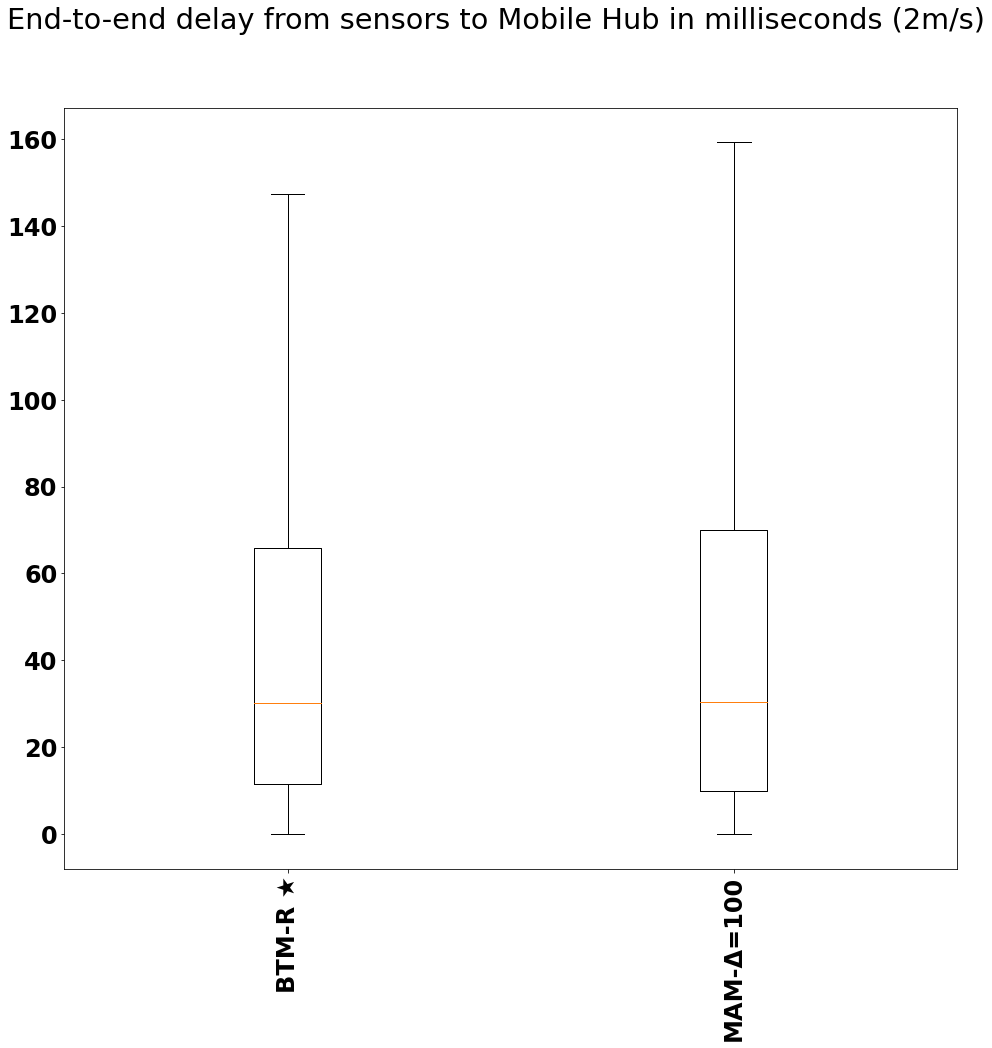

In [201]:

# Create a figure instance
fig = plt.figure(1, figsize=(16, 14))

# Create an axes instance
ax = fig.add_subplot(111)

data_to_plot = [explodedHistBM, explodedHistMAM]
labels = ['BTM-R ★']

d = 100
labels.append('MAM-Δ=' + str(d))


# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

ax.set_xticklabels(labels)

speed = 2
plt.suptitle('End-to-end delay from sensors to Mobile Hub in milliseconds (' + str(speed) + 'm/s)')

plt.xticks(rotation='90.0')

# Save the figure
fig.savefig('mamset-fig6.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)